# R-STDP Learning rule

In [1]:
from pymonntorch import *
import torch

import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, SetCurrent, CurrentSum
from models.encoders import PoissonEncoder, FeedDataset
from models.learnings import  RSTDP
from models.neurons import LIF
from models.synapses import FullyConnectedSynapse
from models.time_res import TimeResolution

from simulate import Simulation
from utils.images import CustomImage


## R-STDP on two pattern of random array

In [2]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((torch.randperm(10), np.zeros(10))),
                                          np.concatenate((np.zeros(10), 2*torch.randperm(10)))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=20,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

/home/amir/Documents/university/Semester 8/Neuroscience/hw3/models/encoders.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  self.dataset = torch.tensor(self.dataset)


Network['Network_1', 'Network'](Neurons: tensor(22)|2 groups, Synapses: tensor(40)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](20){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0828f0f2d0>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=Non

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


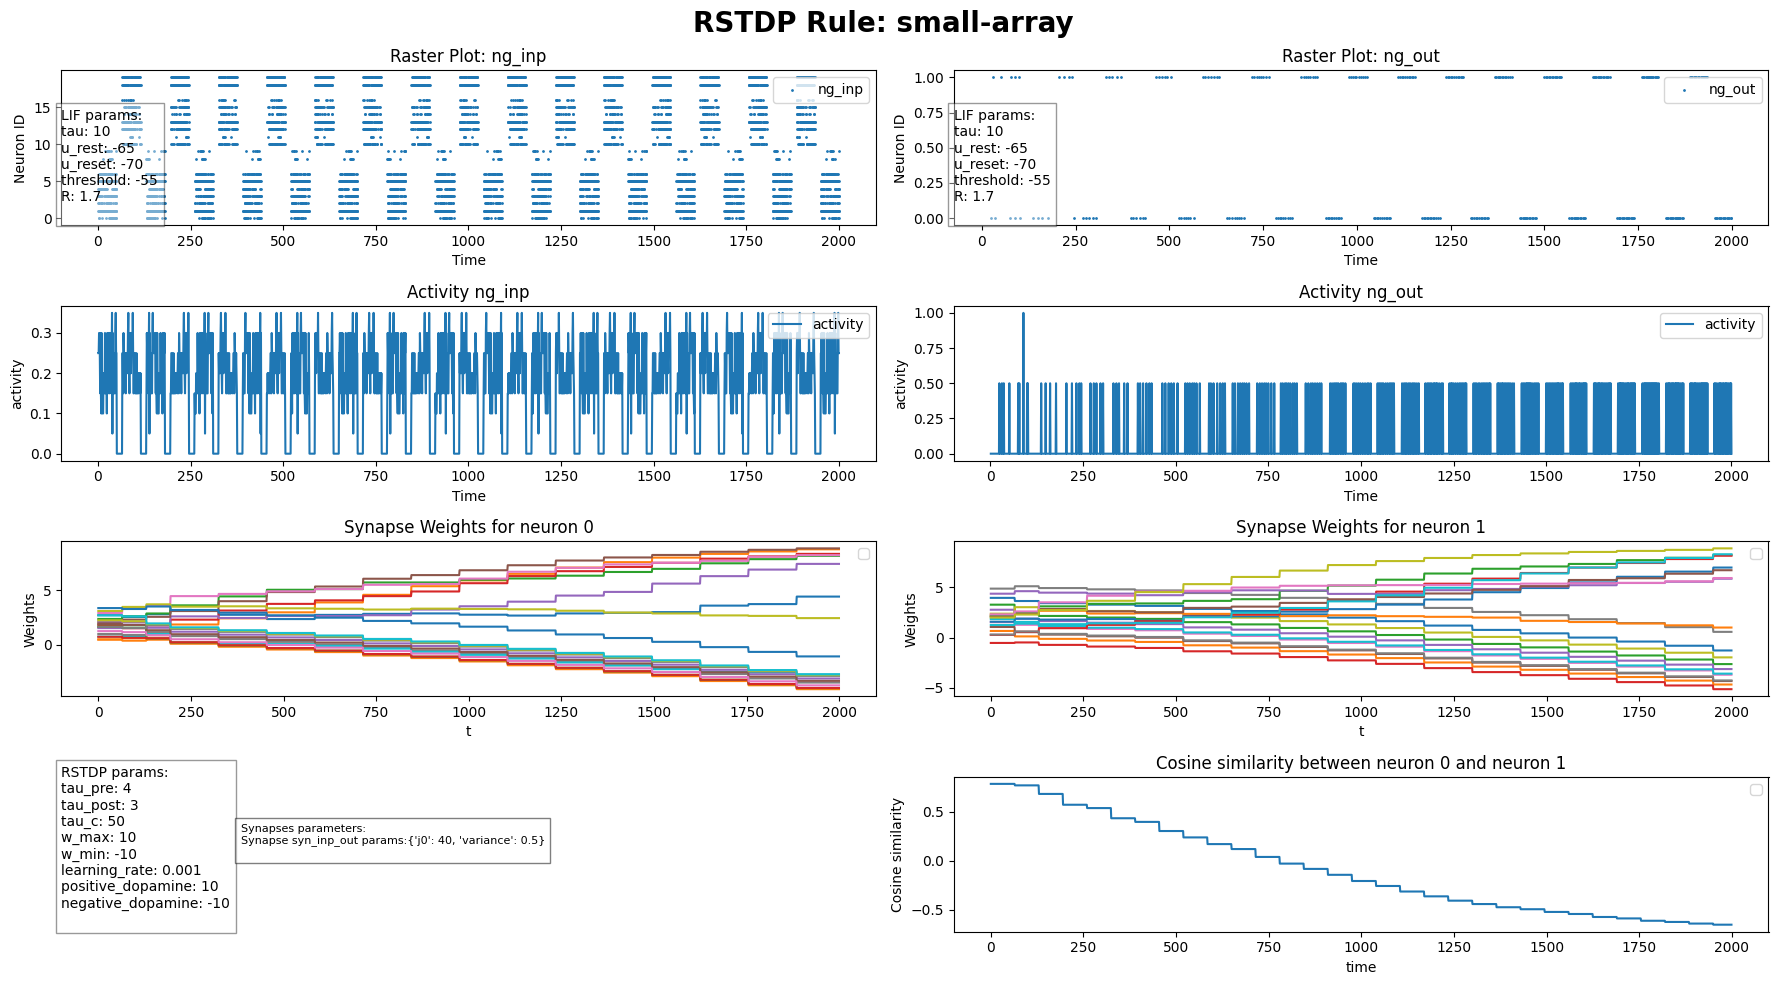

In [3]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: small-array", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-small-array.pdf")
plt.show()

## R-STDP on two pattern

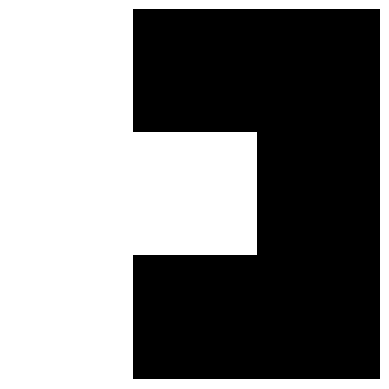

In [4]:
img1 = CustomImage('dataset/pattern1.png')
img1.img_show()

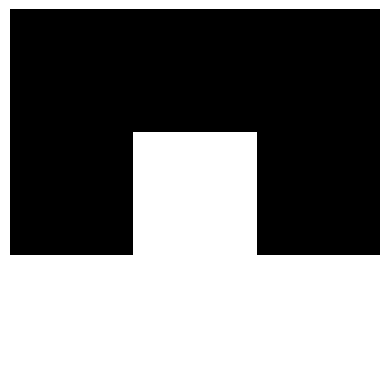

In [5]:
img2 = CustomImage('dataset/pattern2.png')
img2.img_show()

In [6]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(9))),
                                          np.concatenate((np.zeros(9), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=18,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](18){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0719df3410>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=Non

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


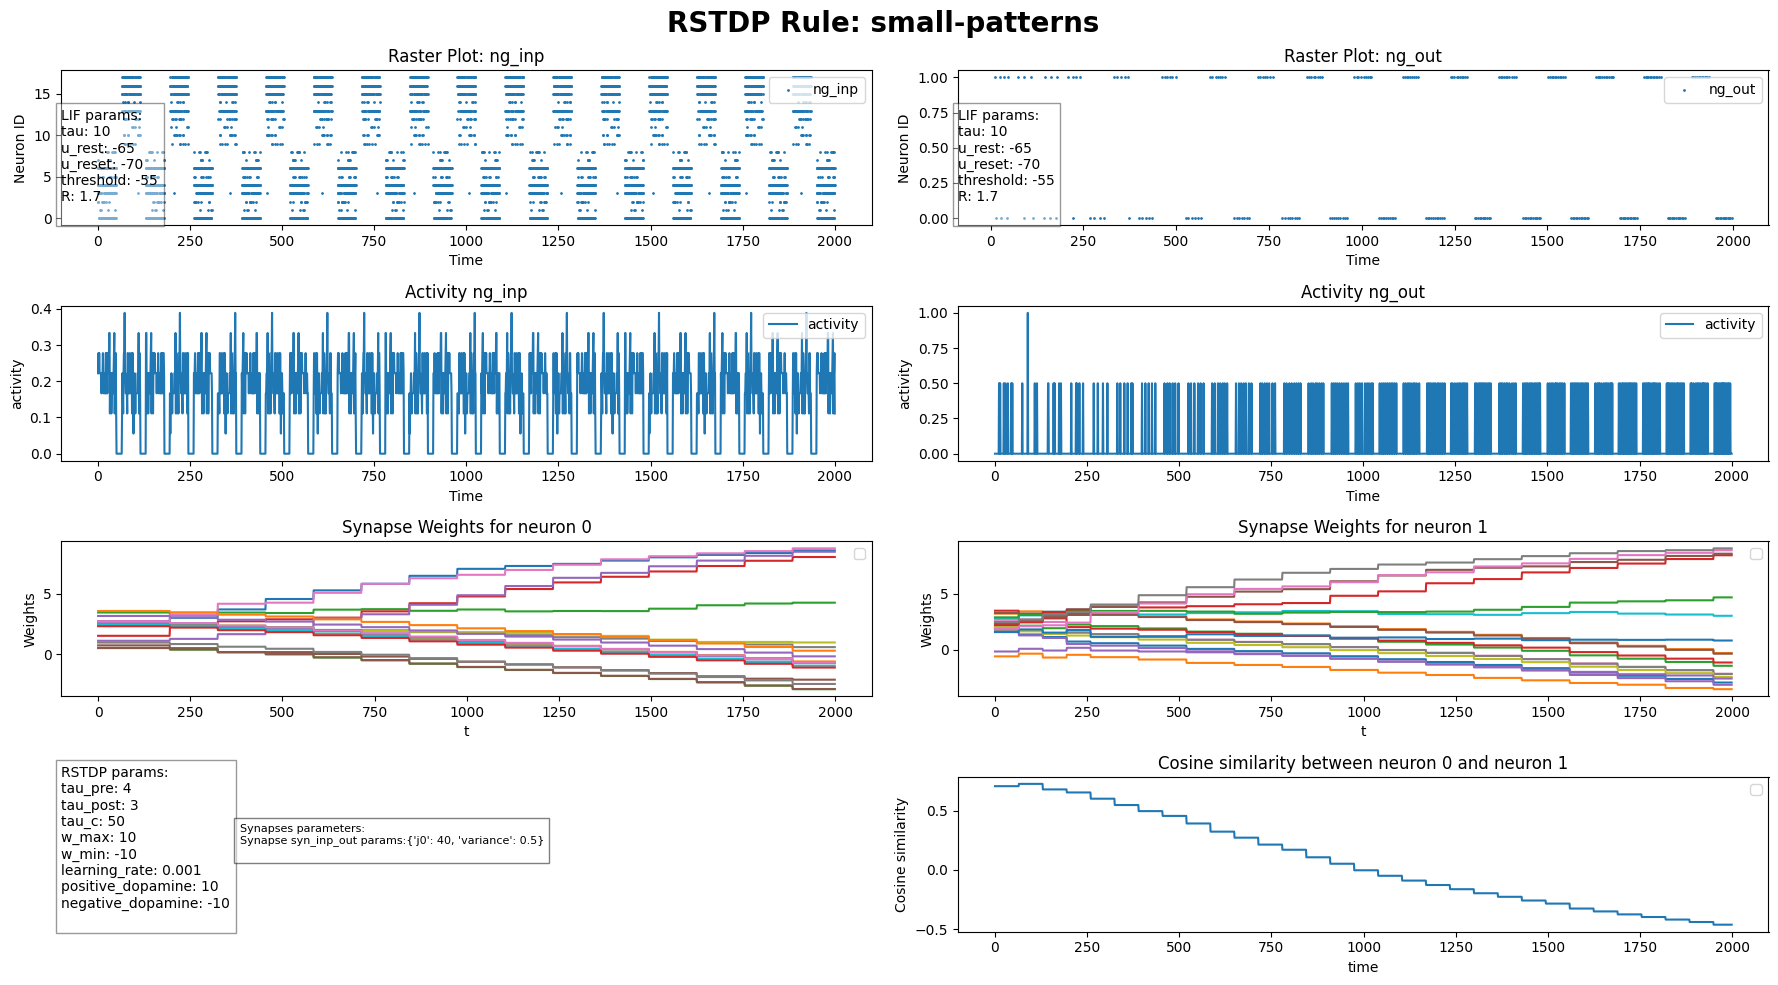

In [7]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: small-patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-small-patterns.pdf")
plt.show()

### Having overlap

In [8]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(5))),
                                          np.concatenate((np.zeros(5), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=14,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(16)|2 groups, Synapses: tensor(28)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](14){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d07182b9490>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=Non

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


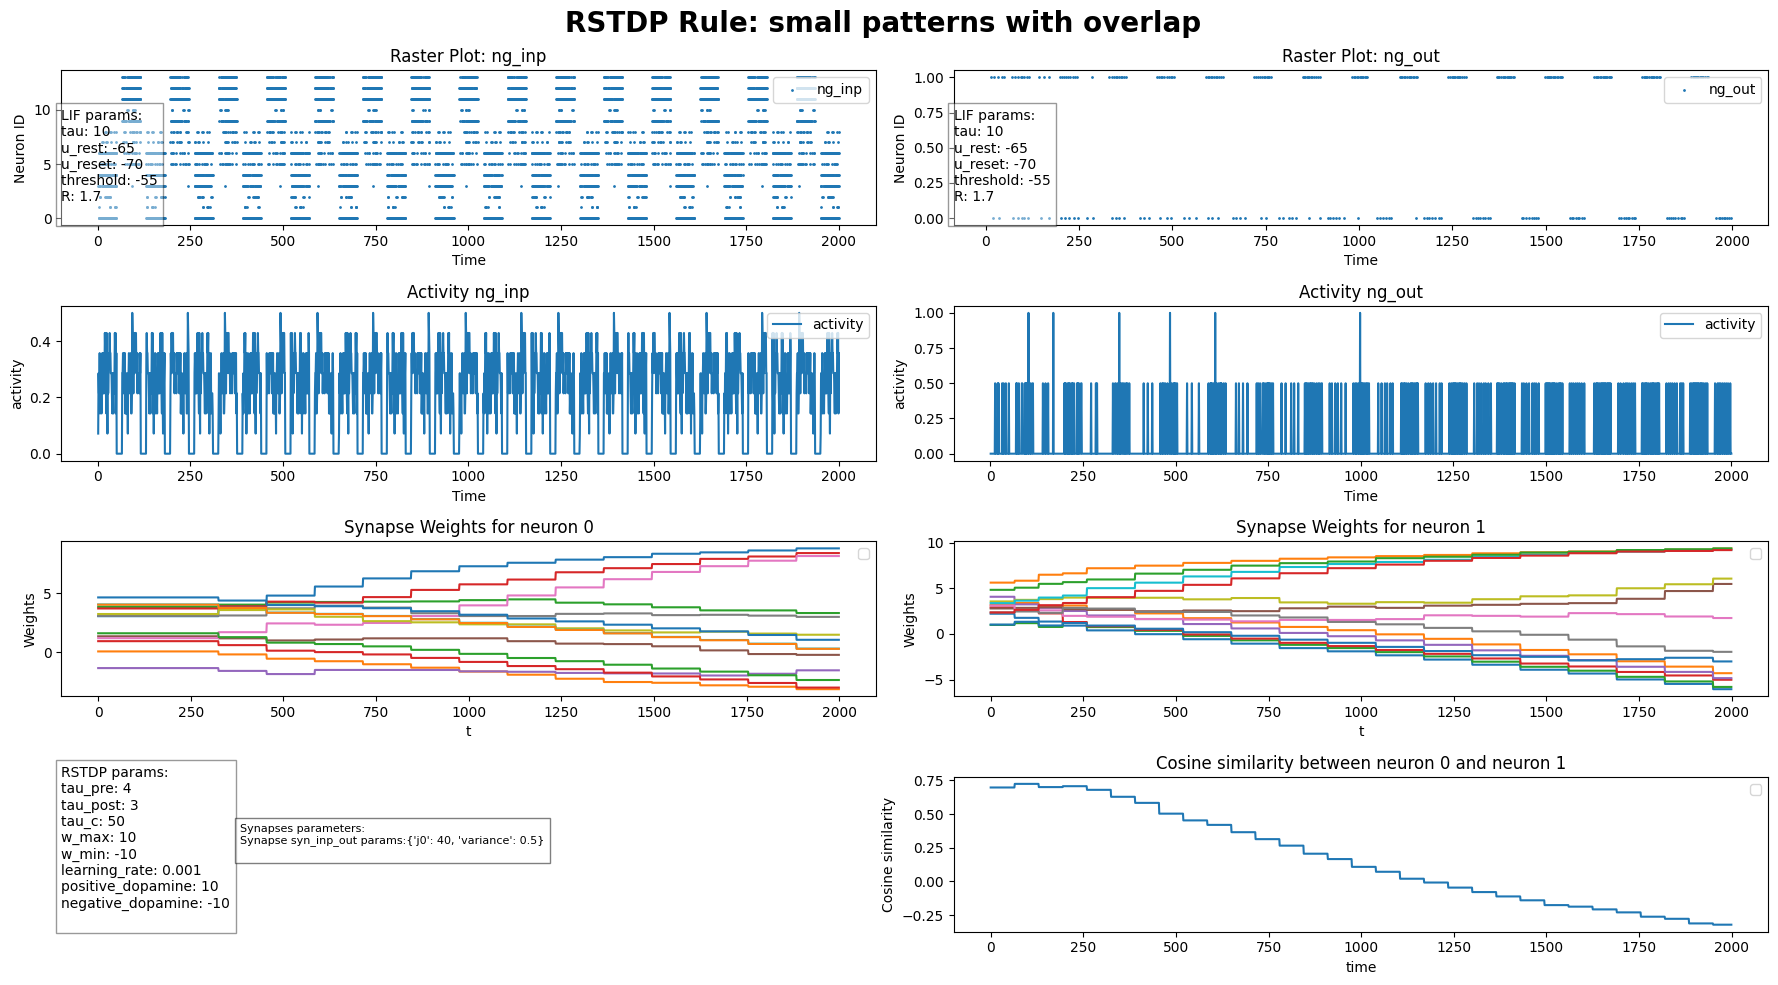

In [9]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: small patterns with overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-small-patterns-overlap.pdf")
plt.show()

### High overlap

In [10]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((np.zeros(1), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=10,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(20)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](10){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0718295290>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=Non

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


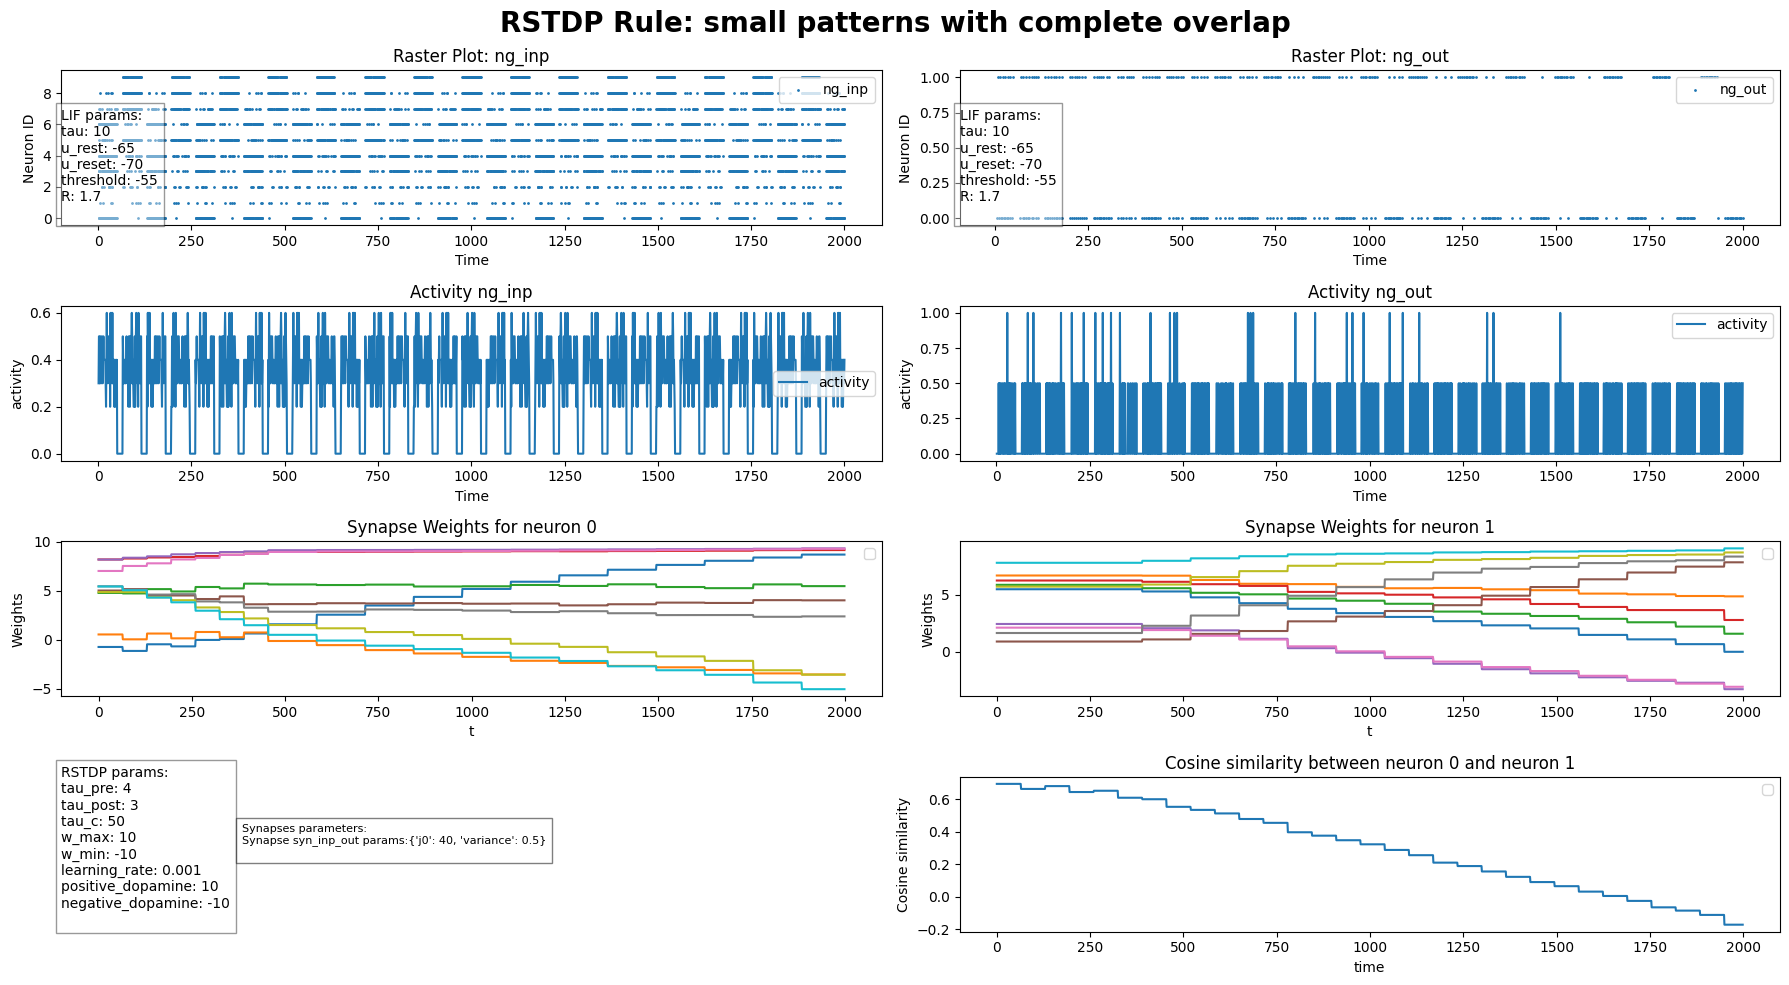

In [11]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: small patterns with complete overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-small-patterns-high-overlap.pdf")
plt.show()

## R-STDP on images

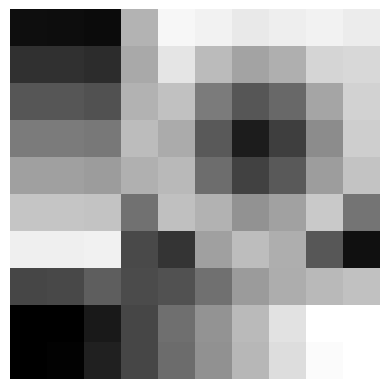

In [12]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(10, 10)
img1.img_show()

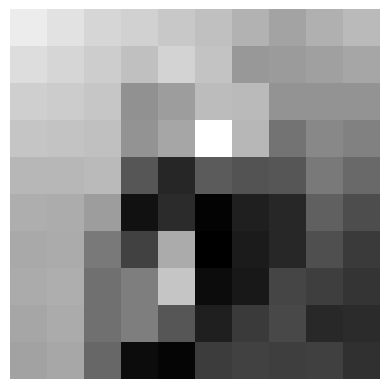

In [13]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(10, 10)
img2.img_show()

In [14]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(100))),
                                          np.concatenate((np.zeros(100), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=200,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(202)|2 groups, Synapses: tensor(400)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](200){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d07180a82d0>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


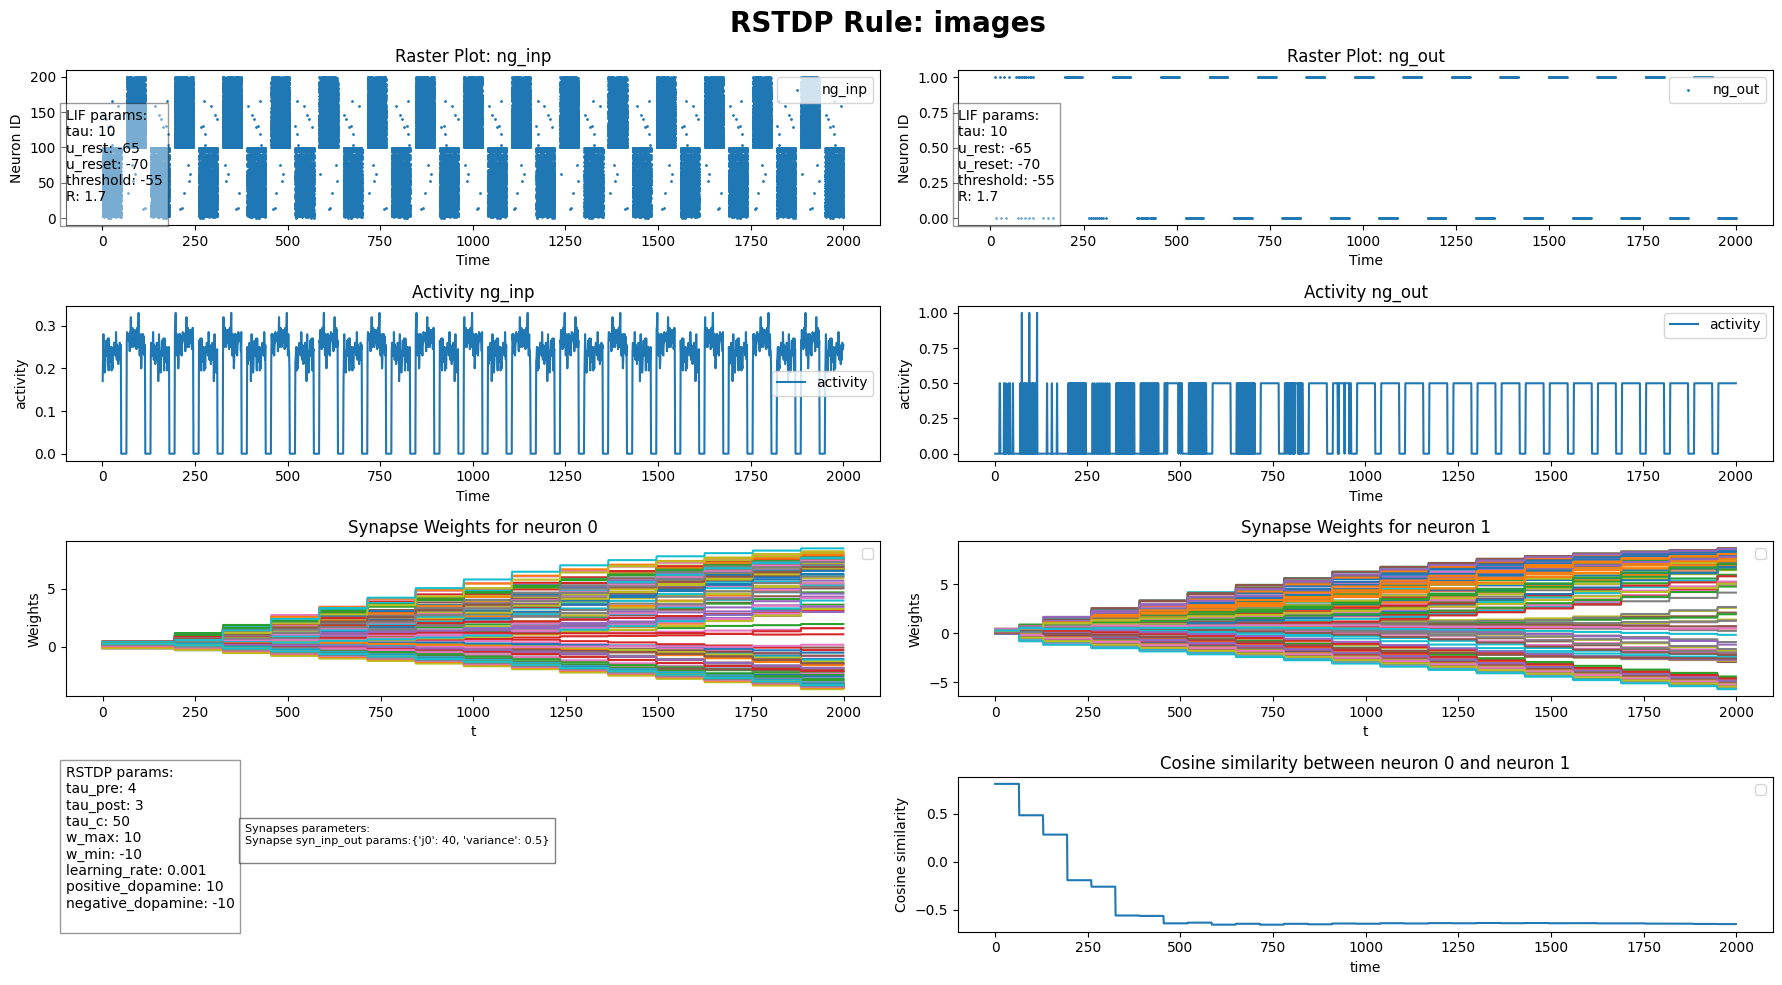

In [15]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images.pdf")
plt.show()

### Overlap on input for image

In [16]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d07180abc10>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


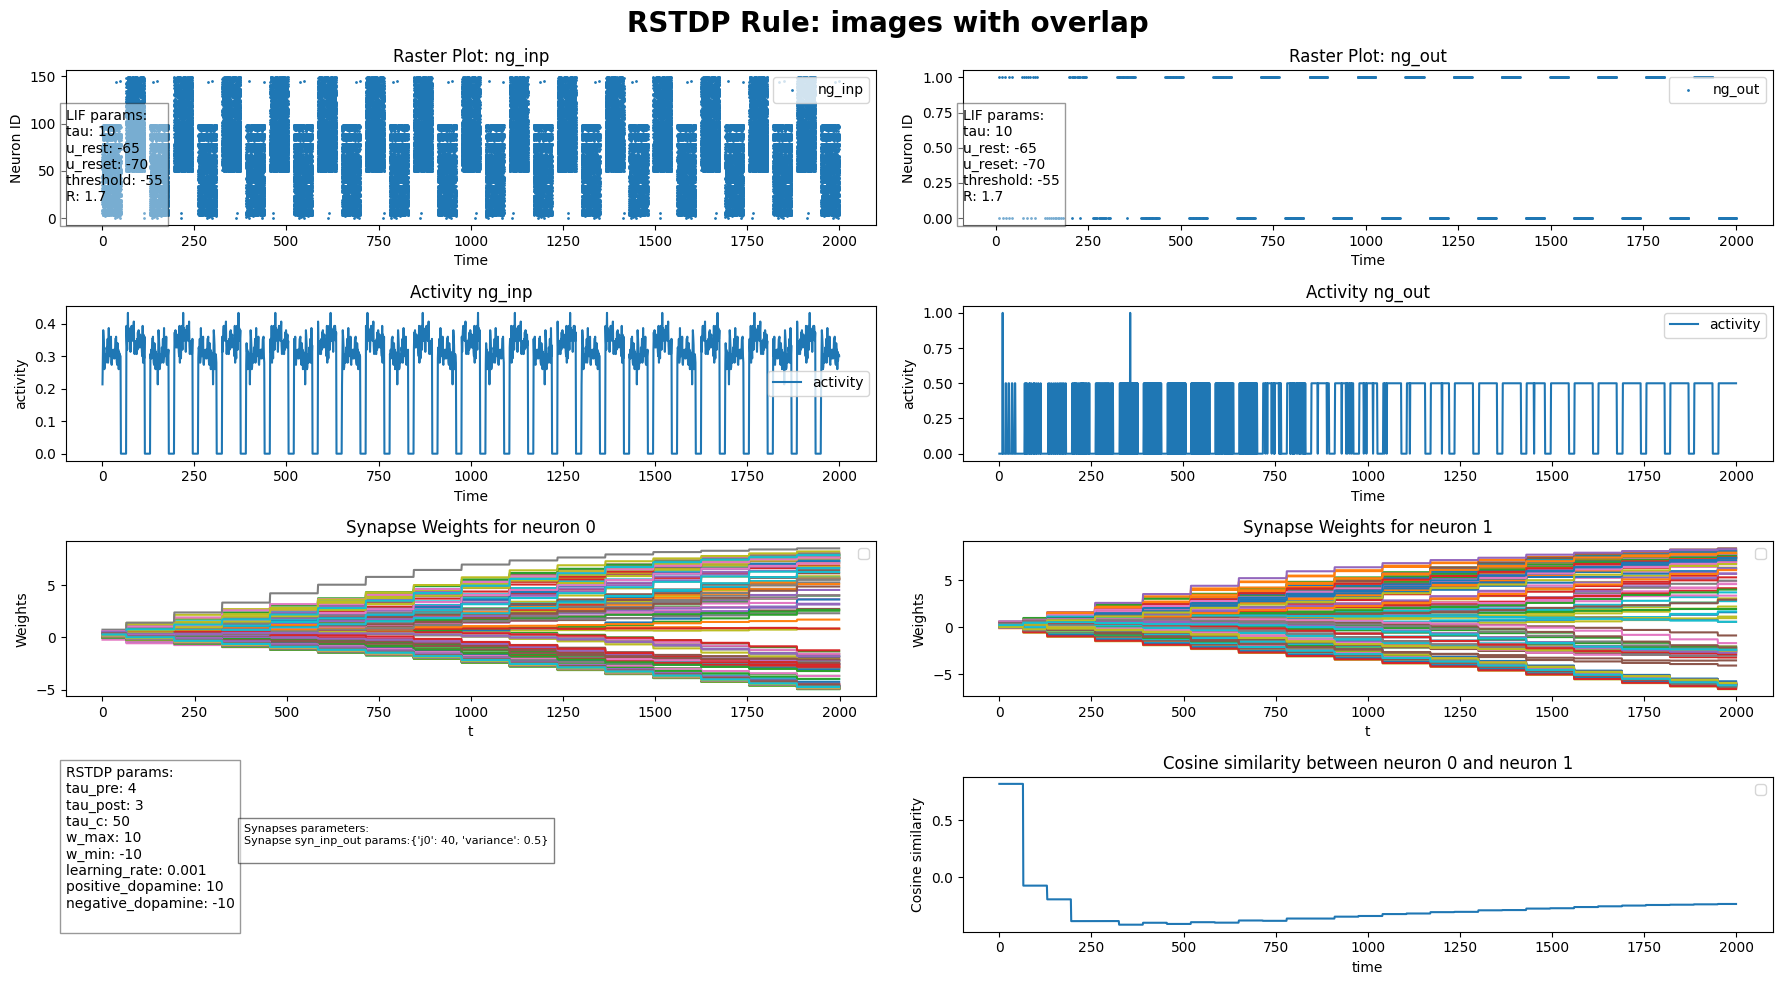

In [17]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-overlap.pdf")
plt.show()

### High overlap on images

In [18]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[img1.img2tensor(),
                                          img2.img2tensor()],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=50,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=100,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=0.9,
                                    negative_dopamine=-0.9),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d07199cea90>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


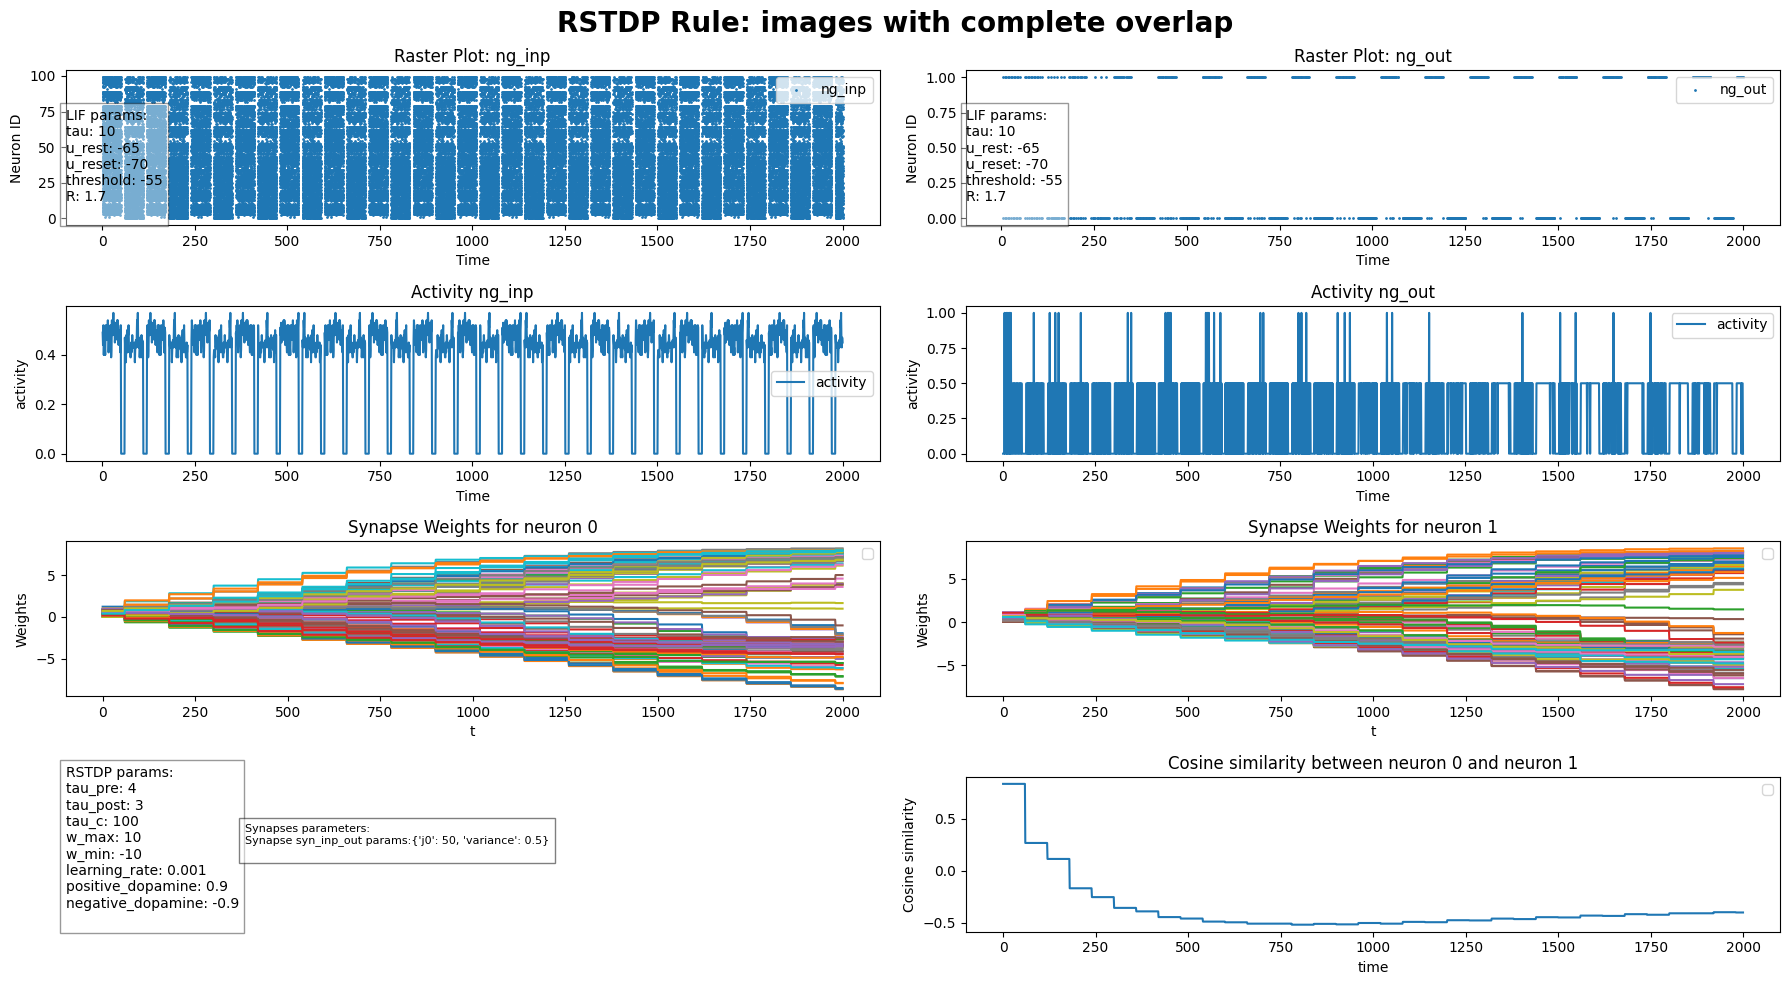

In [19]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with complete overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-high-overlap.pdf")
plt.show()

## Change on initial weights:

In [40]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out_low_weight = sim.add_neuron_group(
    tag="ng_out_low_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_low_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_low_weight_event")
    }
)
ng_out_norm_weight = sim.add_neuron_group(
    tag="ng_out_norm_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_norm_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_norm_weight_event")
    }
)
ng_out_high_weight = sim.add_neuron_group(
    tag="ng_out_high_weight",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_high_weight_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_high_weight_event")
    }
)
syn_inp_out_low = sim.add_synapse_group(
                   tag="syn_inp_out_low",
                   src=ng_inp,
                   dst=ng_out_low_weight,
                   behavior={3: FullyConnectedSynapse(j0=10,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=5,
                                    negative_dopamine=-5),
                             10: Recorder(variables=["W"], tag="syn_inp_out_low_rec"),
                             },
)
syn_inp_out_norm = sim.add_synapse_group(
                   tag="syn_inp_out_norm",
                   src=ng_inp,
                   dst=ng_out_norm_weight,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=5,
                                    negative_dopamine=-5),
                             10: Recorder(variables=["W"], tag="syn_inp_out_norm_rec"),
                             },
)
syn_inp_out_high = sim.add_synapse_group(
                   tag="syn_inp_out_high",
                   src=ng_inp,
                   dst=ng_out_high_weight,
                   behavior={3: FullyConnectedSynapse(j0=100,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=5,
                                    negative_dopamine=-5,
                                    dopamine_method="soft"),
                             10: Recorder(variables=["W"], tag="syn_inp_out_high_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(156)|4 groups, Synapses: tensor(900)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0720bbdc90>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out_low_weight', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_low_weight_rec,)10:EventRecorder(variables=['spike'],g

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

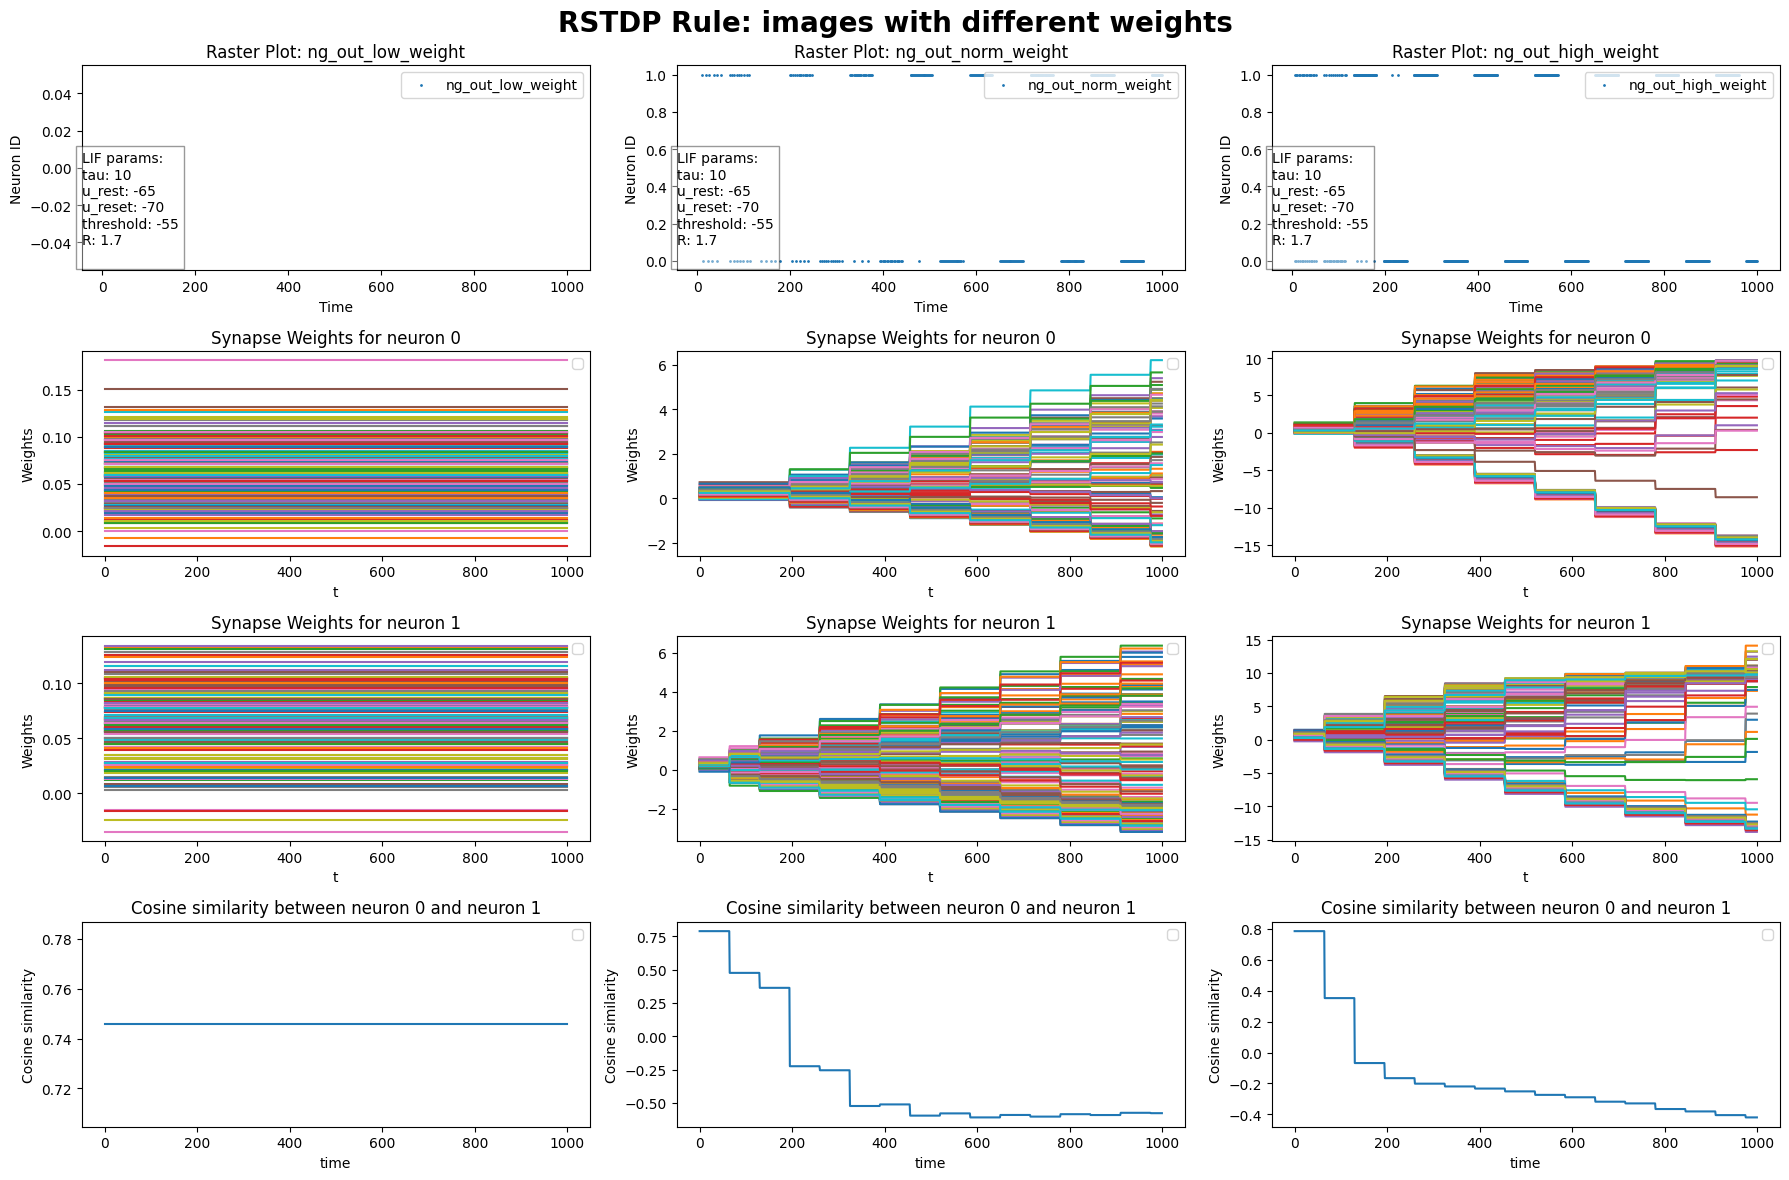

In [42]:
fig = plt.figure(figsize=(18, 12))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 3, 1)  # 3 rows, 1 column, first plot
ng_out_low_weight.add_raster_plot(ax1, s=1)
ng_out_low_weight.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 3, 2, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_norm_weight.add_raster_plot(ax2, s=1)
ng_out_norm_weight.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 3, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_high_weight.add_raster_plot(ax3, s=1)
ng_out_high_weight.add_neuron_model_params_info(ax3, model_idx=6)


ax4 = fig.add_subplot(4, 3, 4)
syn_inp_out_low.add_weights_plot(ax4, neuron_id=0)

ax5 = fig.add_subplot(4, 3, 5)
syn_inp_out_norm.add_weights_plot(ax5, neuron_id=0)

ax6 = fig.add_subplot(4, 3, 6)
syn_inp_out_high.add_weights_plot(ax6, neuron_id=0)

ax7 = fig.add_subplot(4, 3, 7)
syn_inp_out_low.add_weights_plot(ax7, neuron_id=1)

ax8 = fig.add_subplot(4, 3, 8)
syn_inp_out_norm.add_weights_plot(ax8, neuron_id=1)

ax9 = fig.add_subplot(4, 3, 9)
syn_inp_out_high.add_weights_plot(ax9, neuron_id=1)


ax10 = fig.add_subplot(4, 3, 10)
syn_inp_out_low.add_cosine_similarity_plot(ax10,neuron_1=0, neuron_2=1)

ax11 = fig.add_subplot(4, 3, 11)
syn_inp_out_norm.add_cosine_similarity_plot(ax11,neuron_1=0, neuron_2=1)

ax12 = fig.add_subplot(4, 3, 12)
syn_inp_out_high.add_cosine_similarity_plot(ax12,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with different weights", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-different-weights.pdf")
plt.show()

## Change in dopamine:
 neg and pos are equal but change in magnitude

In [22]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=15),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out_low_d = sim.add_neuron_group(
    tag="ng_out_low_d",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_low_d_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_low_d_event")
    }
)
ng_out_norm_d = sim.add_neuron_group(
    tag="ng_out_norm_d",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_norm_d_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_norm_d_event")
    }
)
ng_out_high_d = sim.add_neuron_group(
    tag="ng_out_high_d",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_high_d_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_high_d_event")
    }
)
syn_inp_out_low = sim.add_synapse_group(
                   tag="syn_inp_out_low",
                   src=ng_inp,
                   dst=ng_out_low_d,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=1,
                                    negative_dopamine=-1),
                             10: Recorder(variables=["W"], tag="syn_inp_out_low_rec"),
                             },
)
syn_inp_out_norm = sim.add_synapse_group(
                   tag="syn_inp_out_norm",
                   src=ng_inp,
                   dst=ng_out_norm_d,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10),
                             10: Recorder(variables=["W"], tag="syn_inp_out_norm_rec"),
                             },
)
syn_inp_out_high = sim.add_synapse_group(
                   tag="syn_inp_out_high",
                   src=ng_inp,
                   dst=ng_out_high_d,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=20,
                                    negative_dopamine=-20,
                                    dopamine_method="soft"),
                             10: Recorder(variables=["W"], tag="syn_inp_out_high_rec"),
                             },
)
sim.simulate(iterations=1000)

Network['Network_1', 'Network'](Neurons: tensor(156)|4 groups, Synapses: tensor(900)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0720afc750>,sleep=15,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out_low_d', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_low_d_rec,)10:EventRecorder(variables=['spike'],gap_width=0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

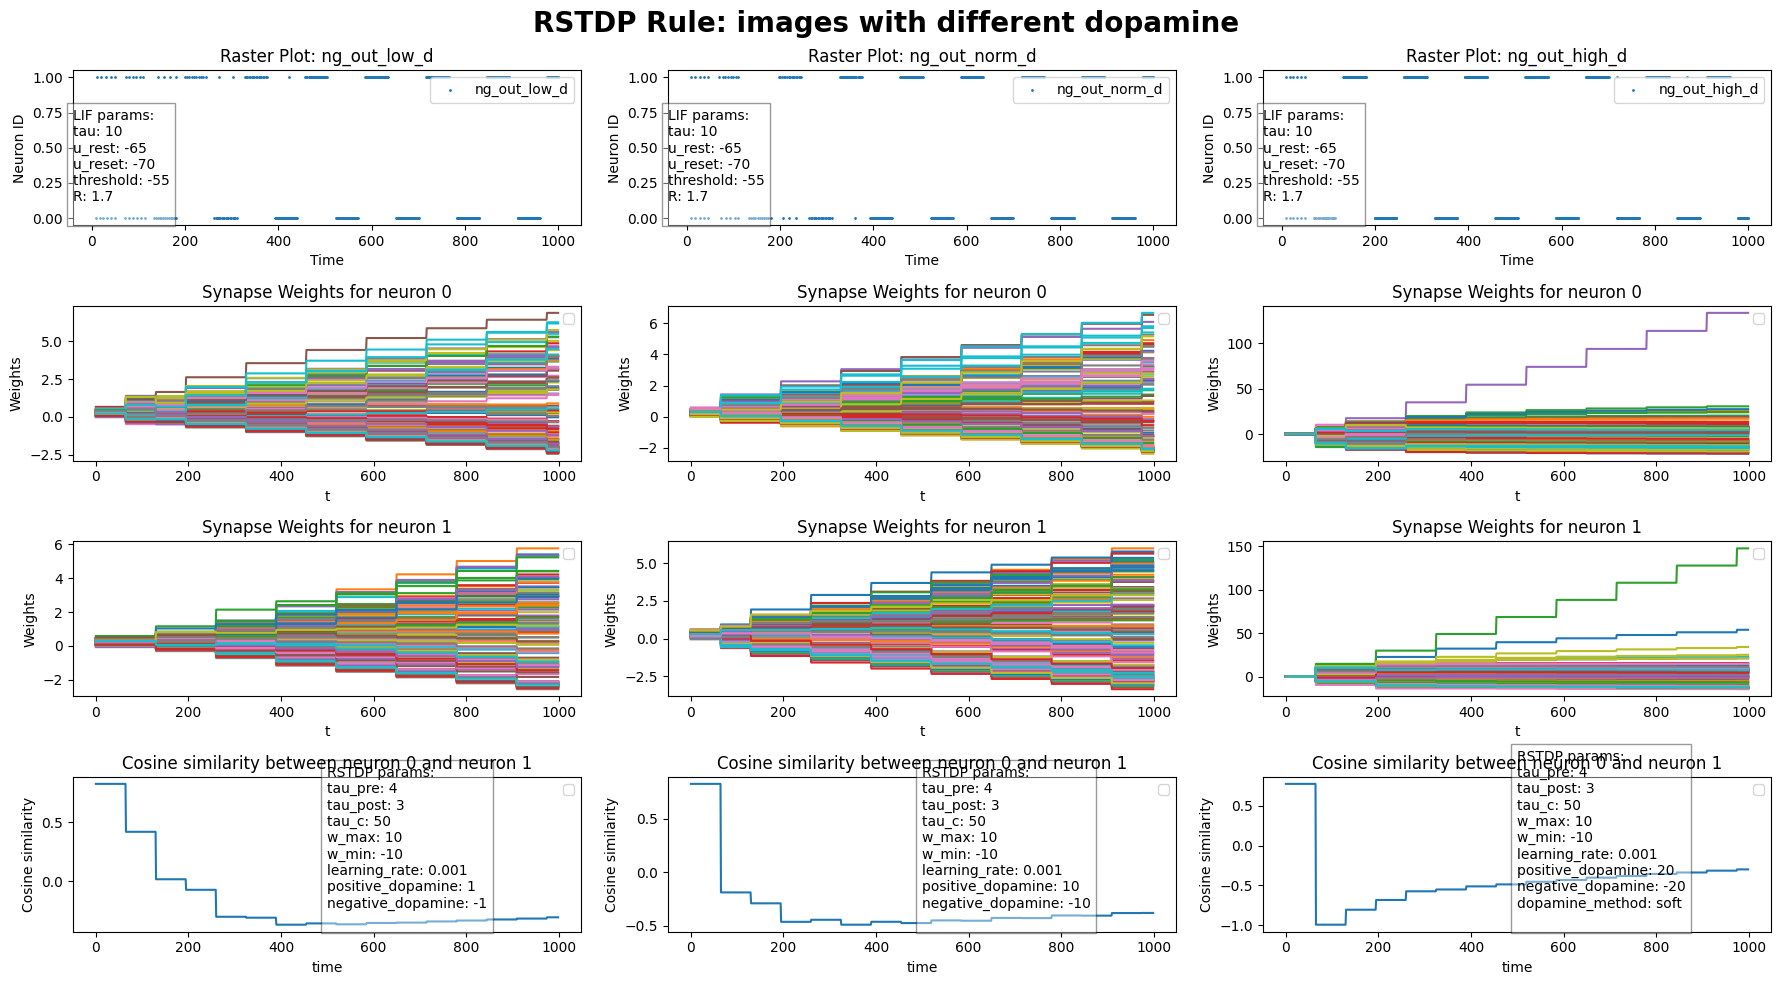

In [23]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 3, 1)  # 3 rows, 1 column, first plot
ng_out_low_d.add_raster_plot(ax1, s=1)
ng_out_low_d.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 3, 2, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_norm_d.add_raster_plot(ax2, s=1)
ng_out_norm_d.add_neuron_model_params_info(ax2, model_idx=6)

ax3 = fig.add_subplot(4, 3, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out_high_d.add_raster_plot(ax3, s=1)
ng_out_high_d.add_neuron_model_params_info(ax3, model_idx=6)


ax4 = fig.add_subplot(4, 3, 4)
syn_inp_out_low.add_weights_plot(ax4, neuron_id=0)

ax5 = fig.add_subplot(4, 3, 5)
syn_inp_out_norm.add_weights_plot(ax5, neuron_id=0)

ax6 = fig.add_subplot(4, 3, 6)
syn_inp_out_high.add_weights_plot(ax6, neuron_id=0)

ax7 = fig.add_subplot(4, 3, 7)
syn_inp_out_low.add_weights_plot(ax7, neuron_id=1)

ax8 = fig.add_subplot(4, 3, 8)
syn_inp_out_norm.add_weights_plot(ax8, neuron_id=1)

ax9 = fig.add_subplot(4, 3, 9)
syn_inp_out_high.add_weights_plot(ax9, neuron_id=1)


ax10 = fig.add_subplot(4, 3, 10)
syn_inp_out_low.add_cosine_similarity_plot(ax10,neuron_1=0, neuron_2=1)
syn_inp_out_low.add_learning_params_info(ax10, synapse_idx=7, text_x=0.5)

ax11 = fig.add_subplot(4, 3, 11)
syn_inp_out_norm.add_cosine_similarity_plot(ax11,neuron_1=0, neuron_2=1)
syn_inp_out_norm.add_learning_params_info(ax11, synapse_idx=7, text_x=0.5)

ax12 = fig.add_subplot(4, 3, 12)
syn_inp_out_high.add_cosine_similarity_plot(ax12,neuron_1=0, neuron_2=1)
syn_inp_out_high.add_learning_params_info(ax12, synapse_idx=7, text_x=0.5)

fig.suptitle("RSTDP Rule: images with different dopamine", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-different-dopamine.pdf")
plt.show()

# Adjusted model:

In [24]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[img1.img2tensor(),
                                          img2.img2tensor()],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: RSTDP(tau_pre=4,
                       tau_post=3,
                       tau_c=100,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001,
                       positive_dopamine=1,
                       negative_dopamine=-1),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0719745bd0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


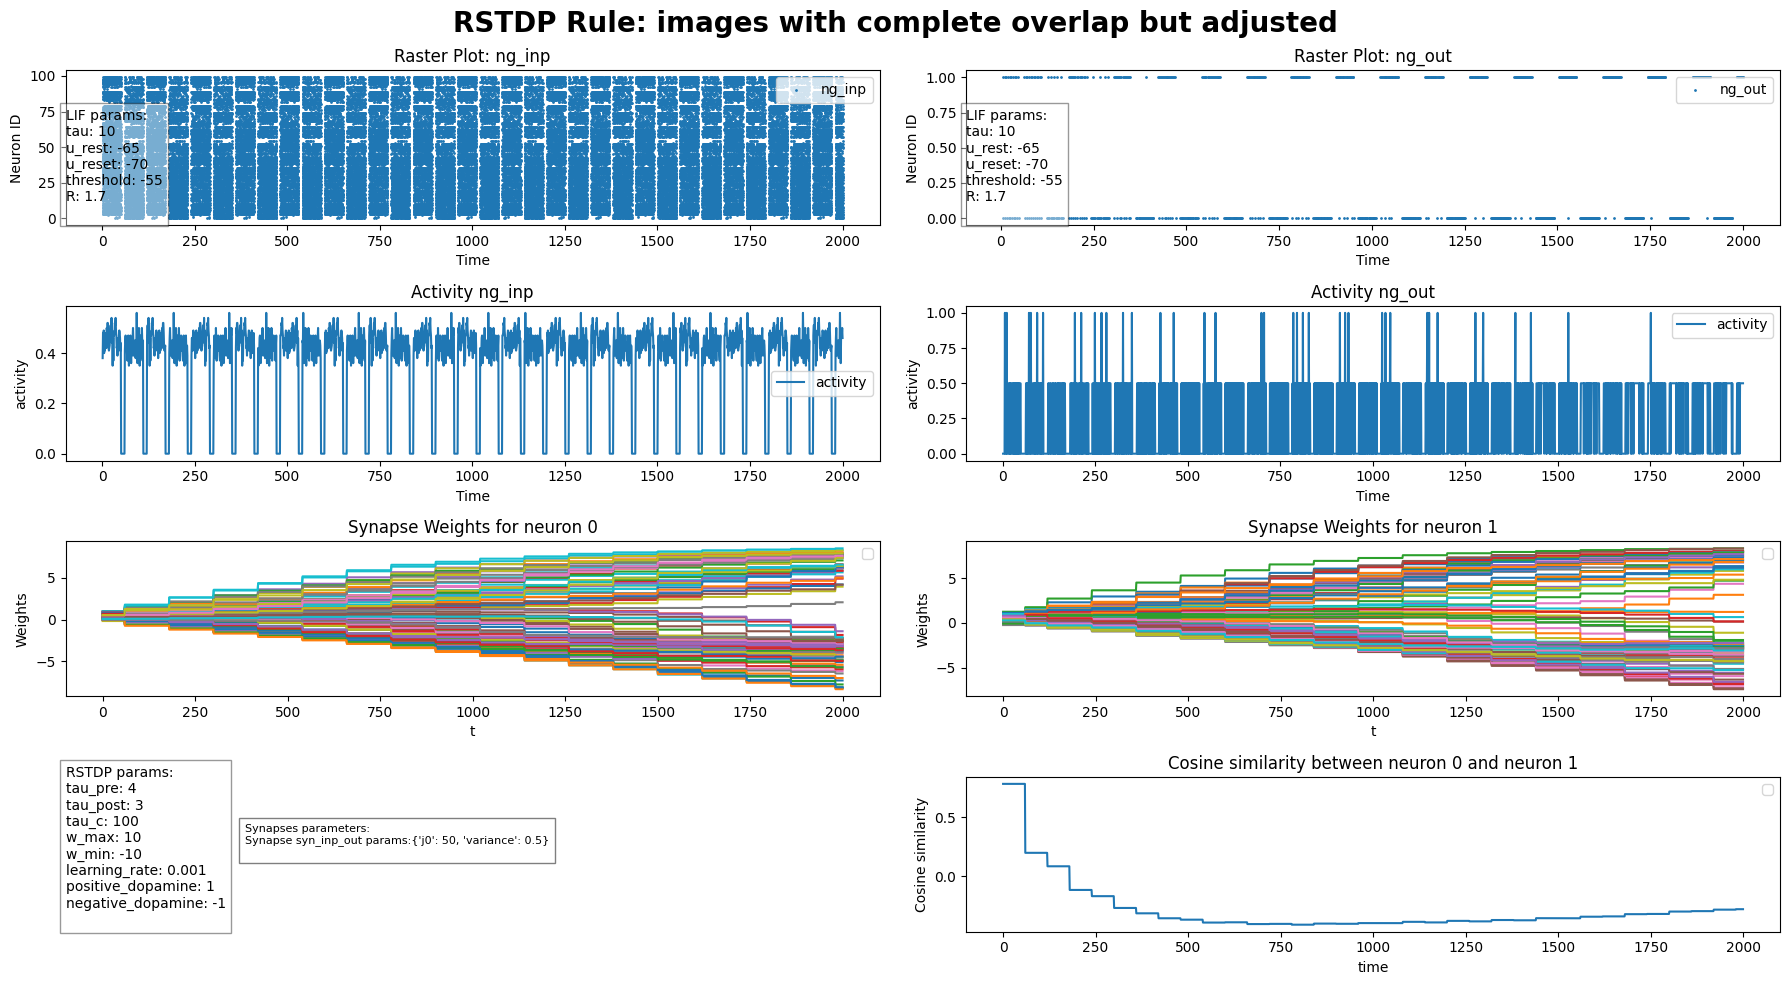

In [25]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8, neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with complete overlap but adjusted", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-high-overlap-adjusted.pdf")
plt.show()

# Adding one neuron to input and output layer

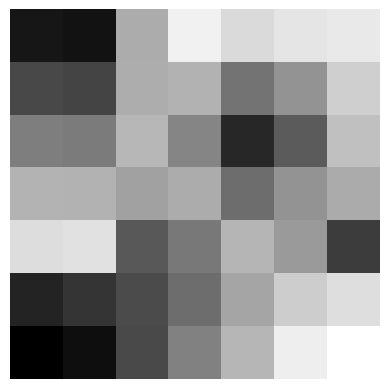

In [51]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(7,7)
img1.img_show()

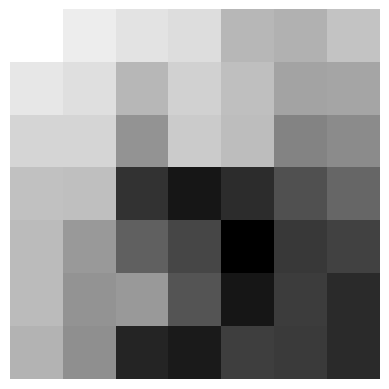

In [52]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(7,7)
img2.img_show()

### using Weights to prevent added neuron to spike

In [66]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=20,
                                    negative_dopamine=-20,
                                    dopamine_method="soft",
                                    ),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
syn_inp_out.W[:, -1] = 0.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d070d92d5d0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


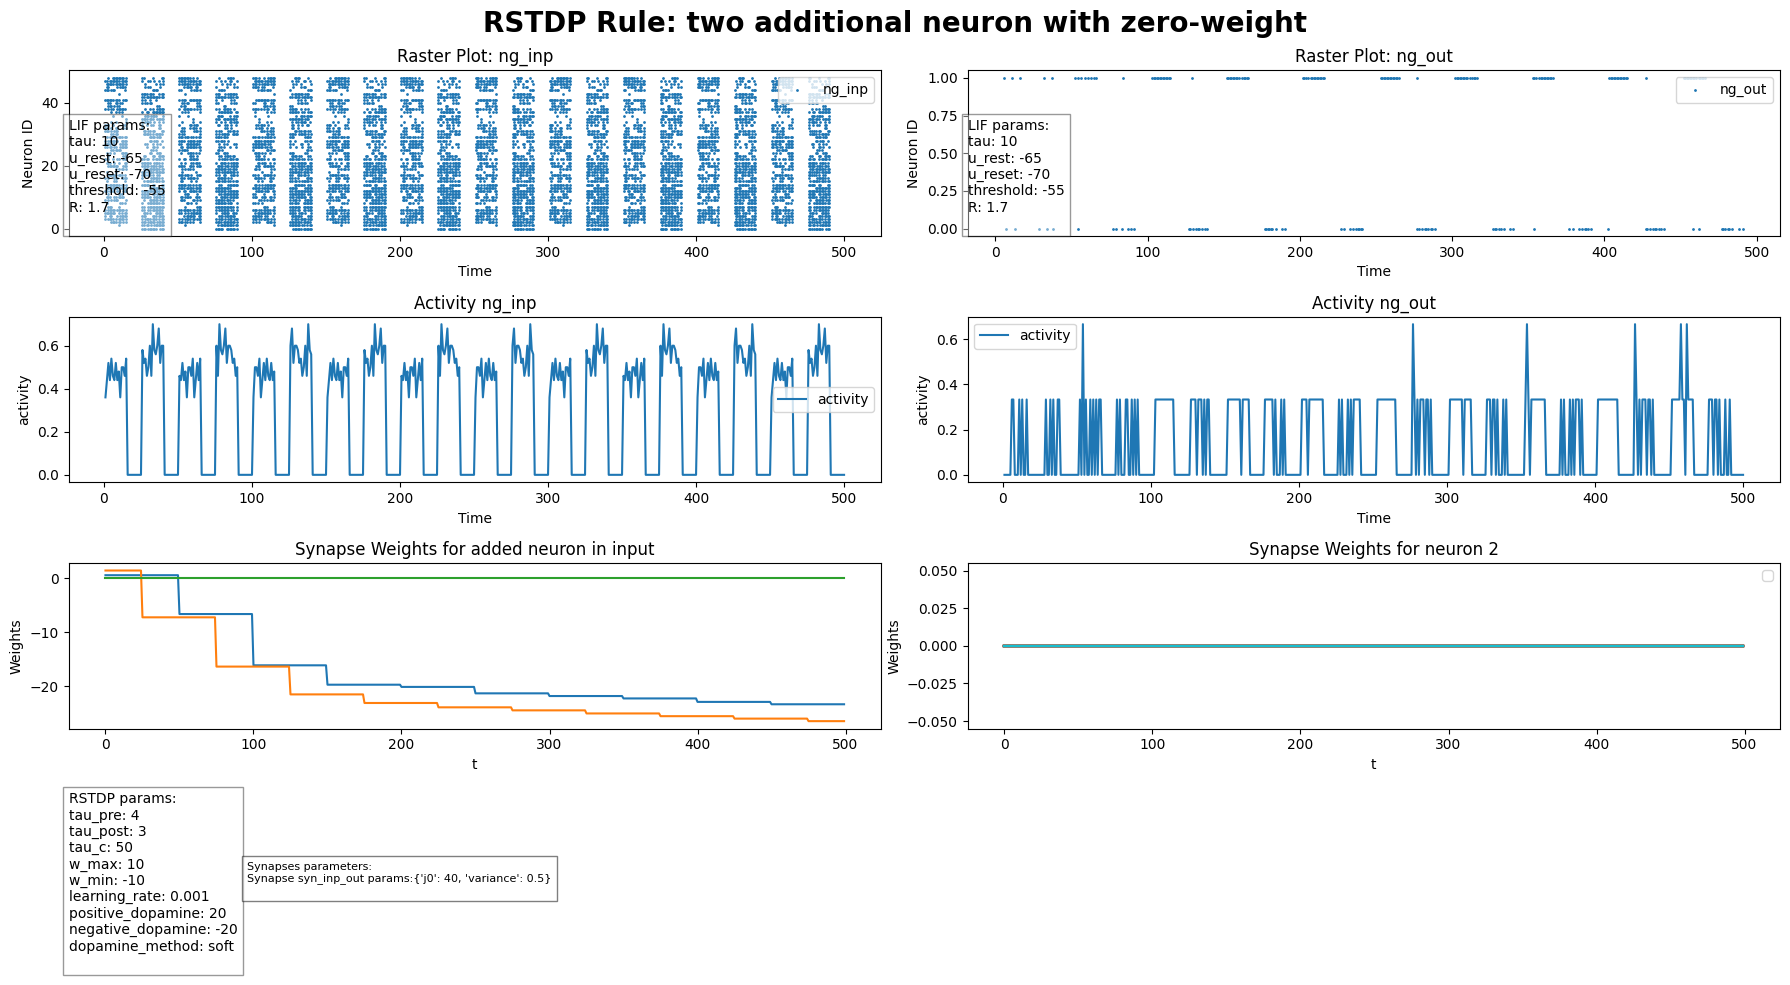

In [67]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("RSTDP Rule: two additional neuron with zero-weight", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-two-additional-neuron-zero-weight.pdf")
plt.show()

### using threshold to prevent added neuron to spike

In [59]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=20,
                                    negative_dopamine=-20,
                                    dopamine_method="soft"),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
ng_out.threshold[-1] = 100.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d0720c2d6d0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


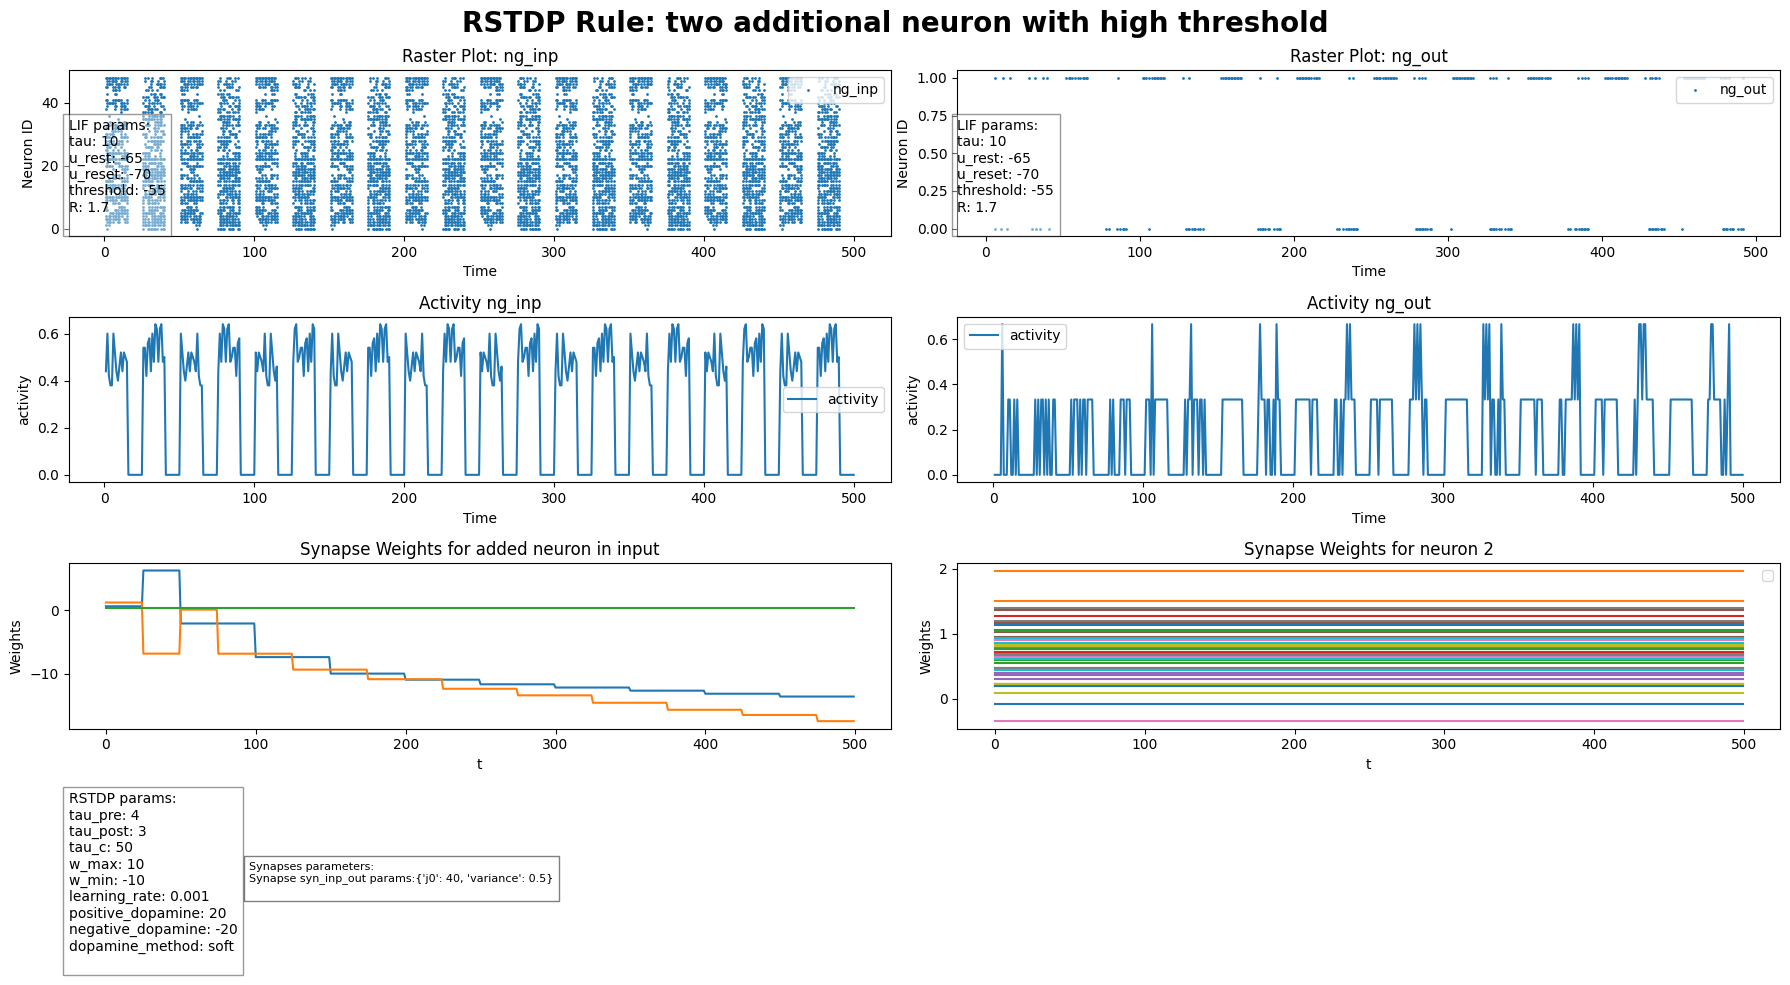

In [60]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("RSTDP Rule: two additional neuron with high threshold", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-two-additional-neuron-zero-threshold.pdf")
plt.show()

### with normalization off

In [61]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(1))),
                                          np.concatenate((img2.img2tensor(), np.zeros(1)))],
                                 duration=15,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=3,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=0),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
                   tag="syn_inp_out",
                   src=ng_inp,
                   dst=ng_out,
                   behavior={3: FullyConnectedSynapse(j0=40,
                                                      variance=0.5),
                             7: RSTDP(tau_pre=4,
                                    tau_post=3,
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=20,
                                    negative_dopamine=-20,
                                    dopamine_method="soft",
                                    normalization=False),
                             10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
                             },
)

sim.initialize()
ng_out.threshold[-1] = 100.0
sim.simulate_iterations(iterations=500)

Network['Network_1', 'Network'](Neurons: tensor(53)|2 groups, Synapses: tensor(150)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d072076ae50>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](3){1:SetCurrent(value=0,)2:ConstantCurrent(value=0,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=No

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


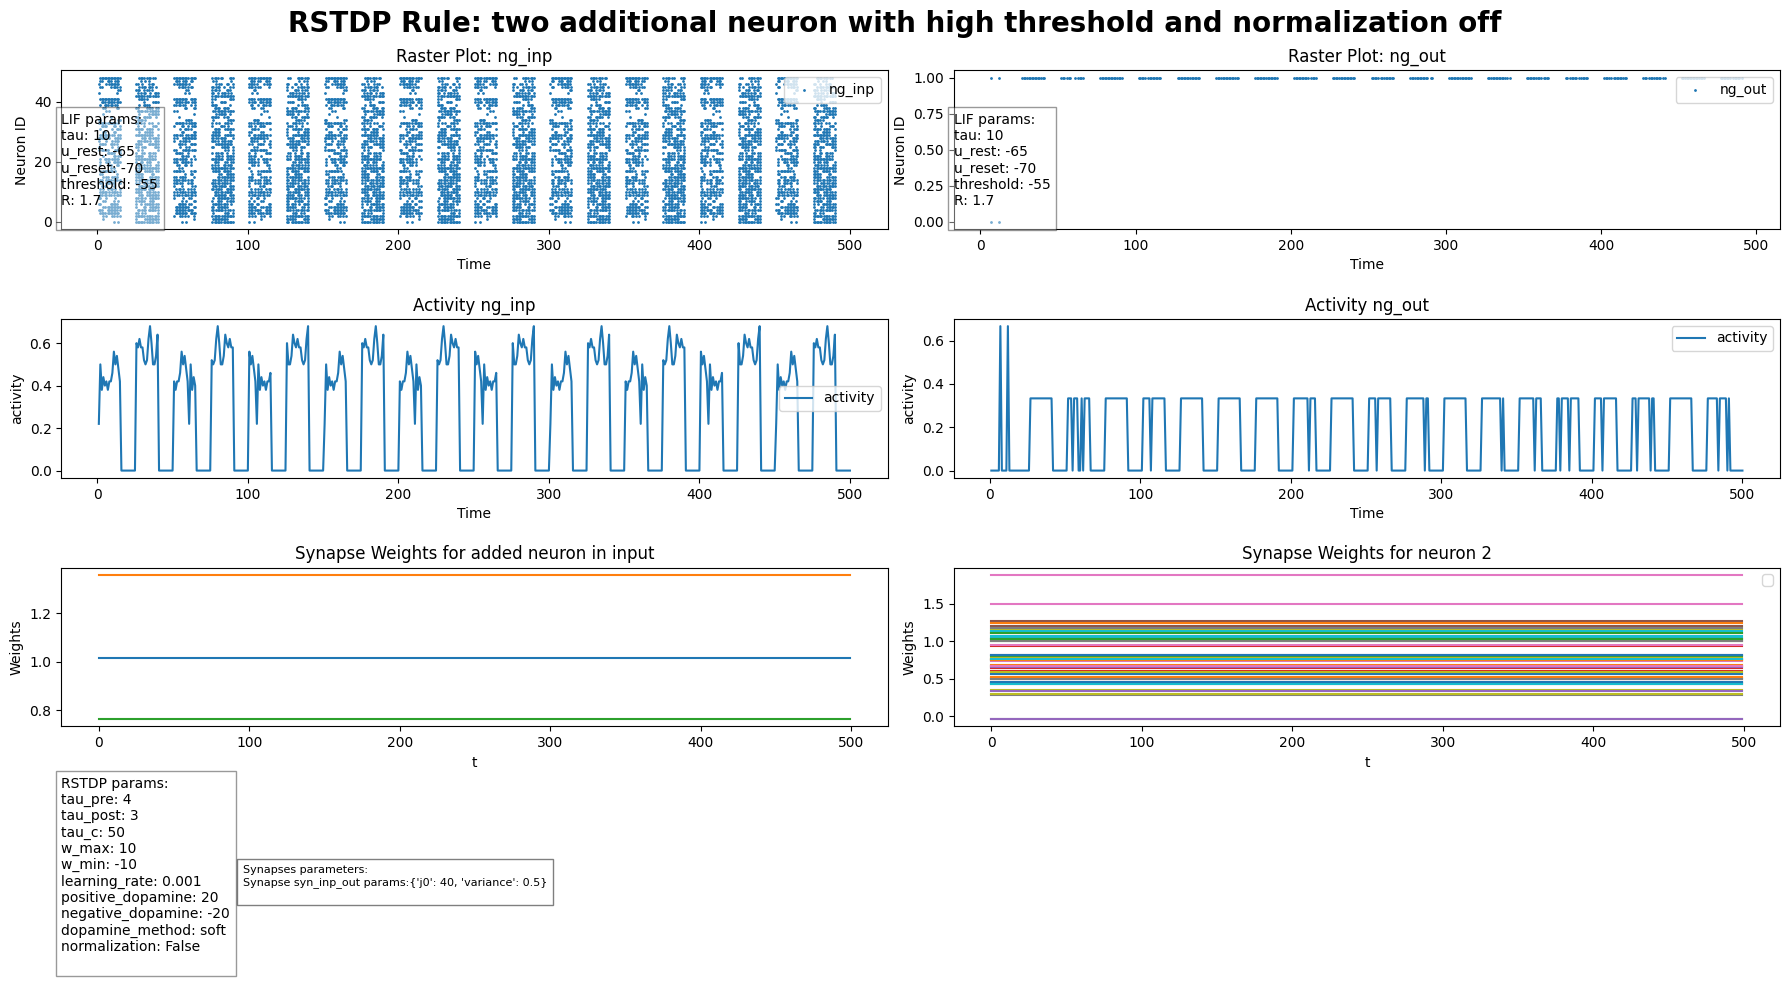

In [65]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
# syn_inp_out.add_weights_plot(ax5, neuron_id=0)
ax5.plot(syn_inp_out[f"syn_inp_out_rec", 0].variables["W"][:, -1, :])
ax5.set_xlabel('t')
ax5.set_ylabel('Weights')
ax5.set_title(f'Synapse Weights for added neuron in input')

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=2)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)

fig.suptitle("RSTDP Rule: two additional neuron with high threshold and normalization off", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-two-additional-neuron-zero-threshold-norm-off.pdf")
plt.show()

# Background Activity

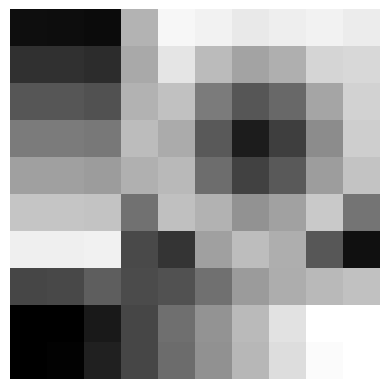

In [69]:
img1 = CustomImage('dataset/slope.tif')
img1.resize_image(10, 10)
img1.img_show()

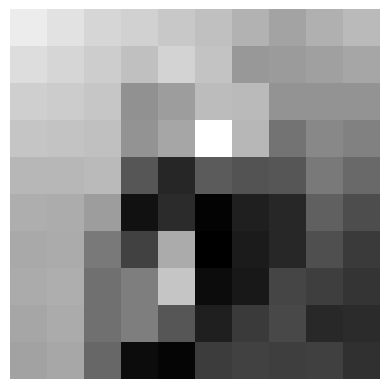

In [70]:
img2 = CustomImage('dataset/bird.tif')
img2.resize_image(10, 10)
img2.img_show()

In [75]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=1, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=1, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: RSTDP(tau_pre=4,
                       tau_post=3,
                       tau_c=100,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001,
                       positive_dopamine=20,
                       negative_dopamine=-20),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=1,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d070d96c690>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=1,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=[

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


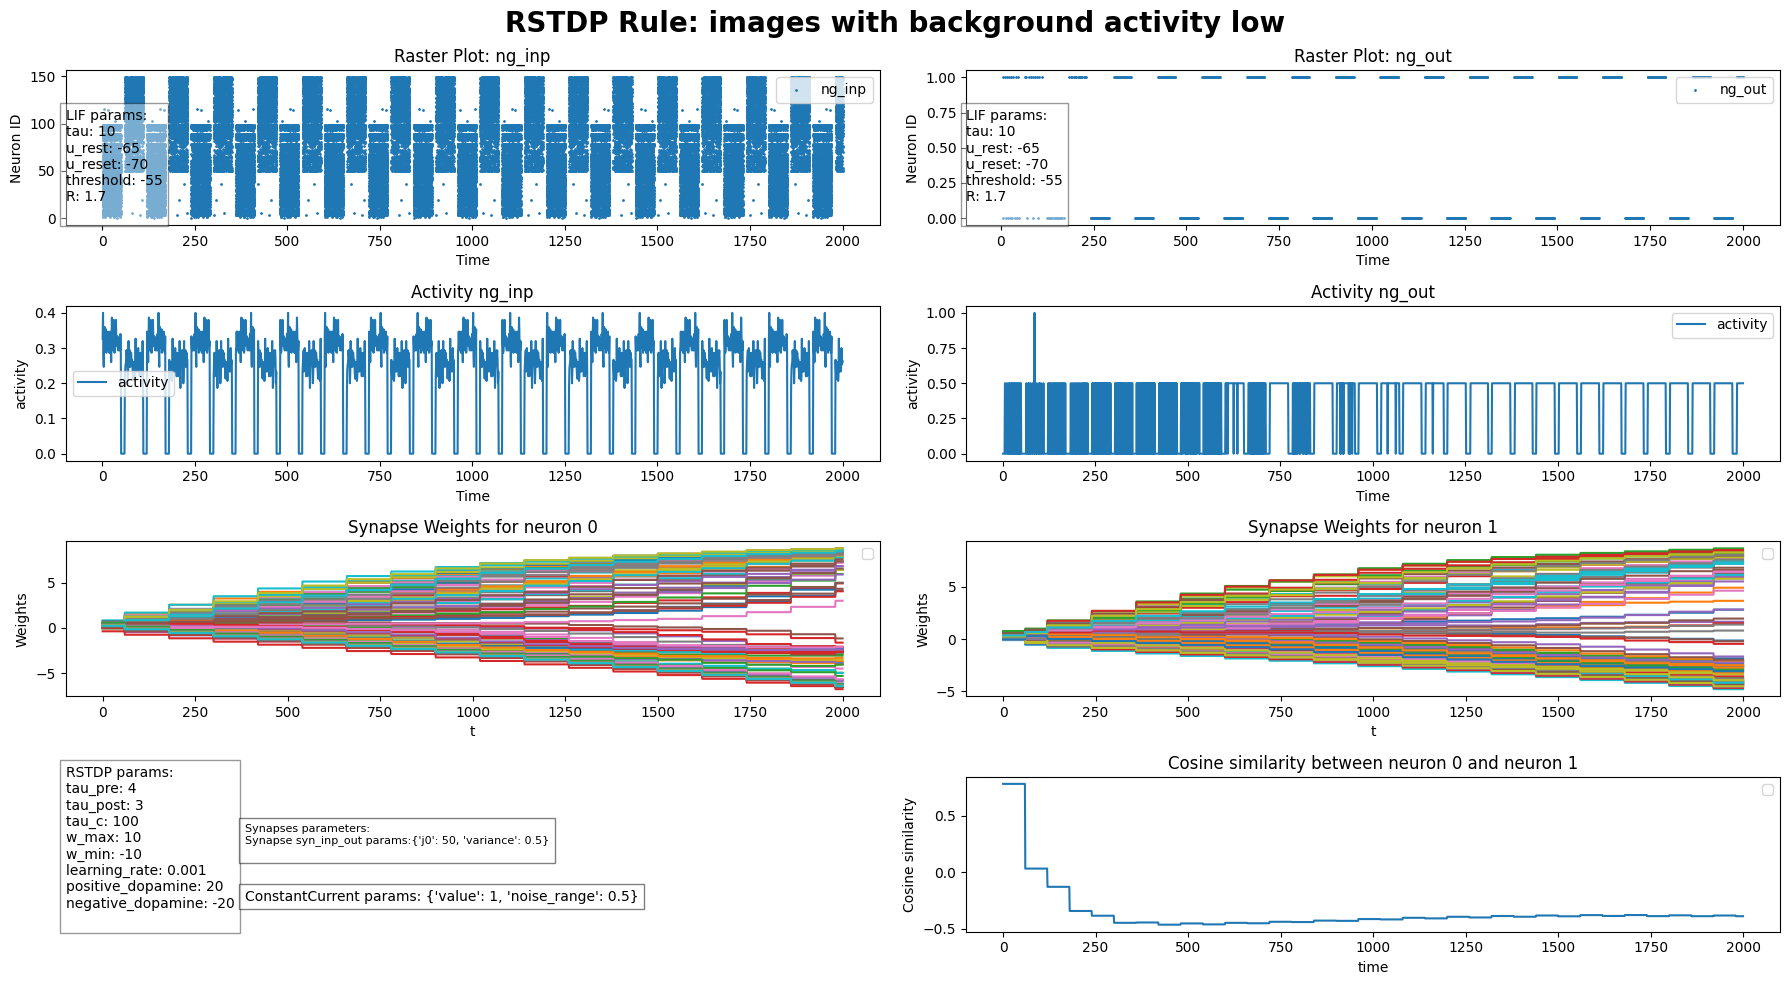

In [76]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with background activity low", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-background-activity-low.pdf")
plt.show()

### more background activity

In [77]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=4, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=4, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: RSTDP(tau_pre=4,
                       tau_post=3,
                       tau_c=100,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001,
                       positive_dopamine=20,
                       negative_dopamine=-20),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=4,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d07209958d0>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=4,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(variables=[

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


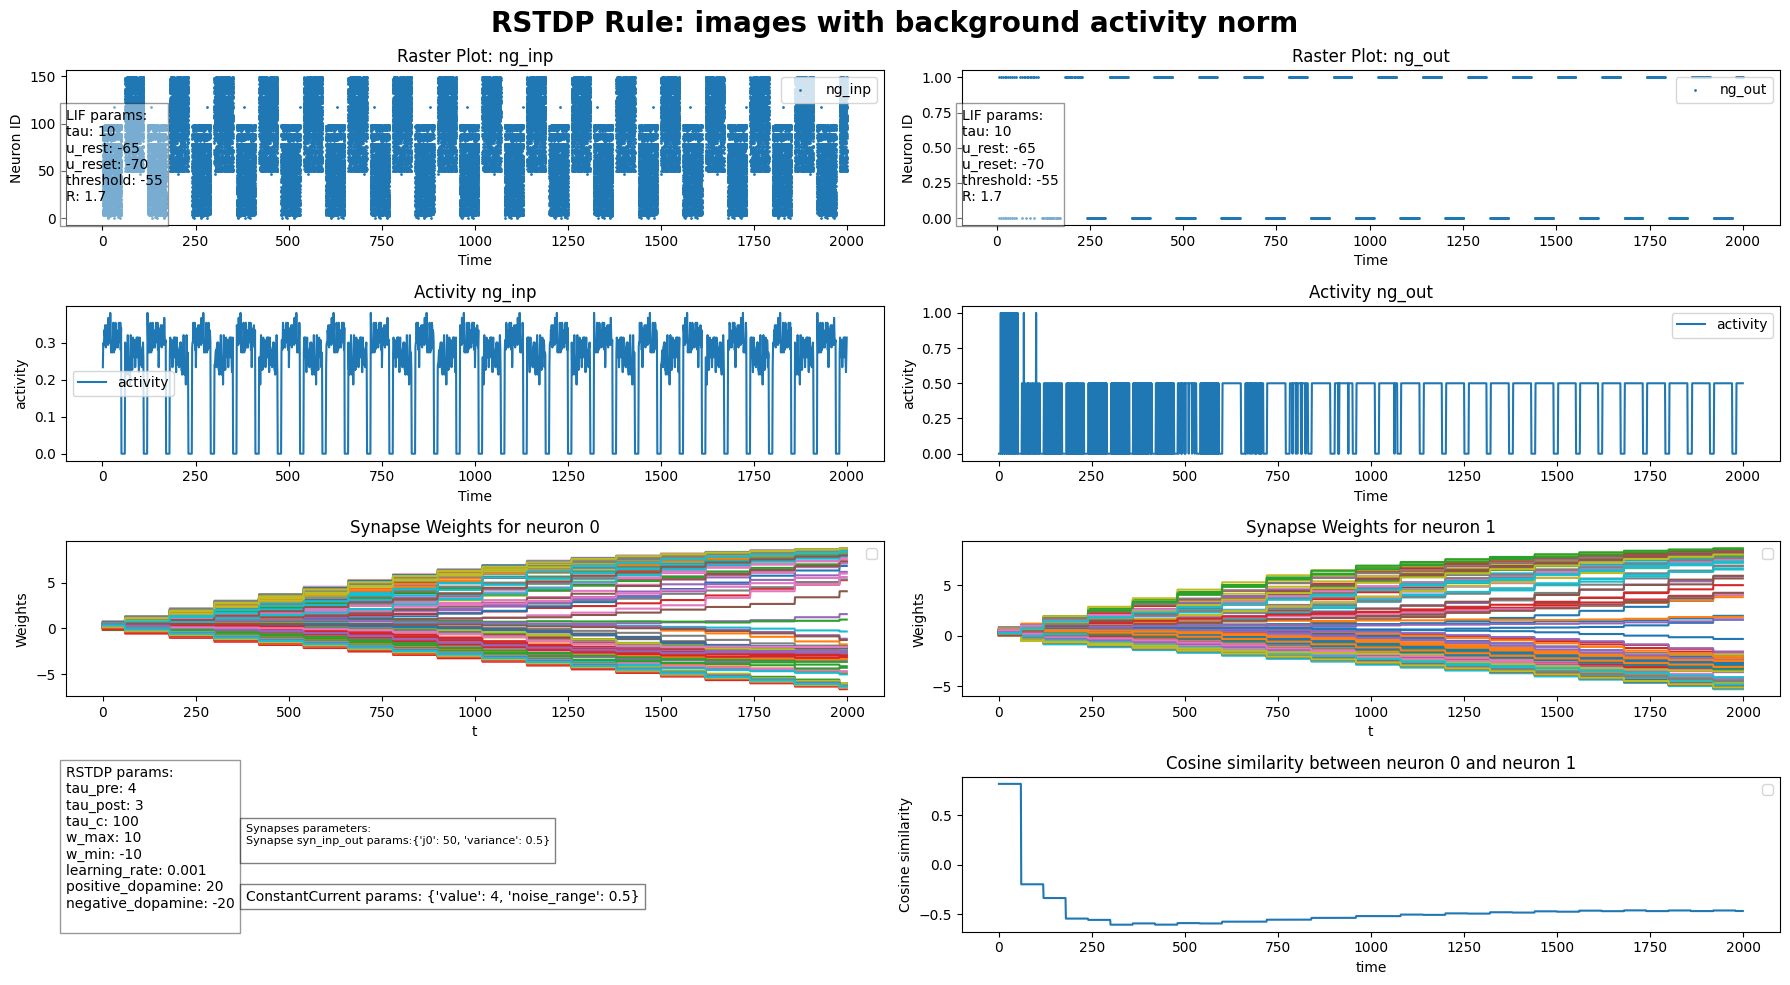

In [78]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with background activity norm", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-background-activity-norm.pdf")
plt.show()

### high background activity


In [79]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0, )}), )

encoded_dataset = PoissonEncoder(dataset=[np.concatenate((img1.img2tensor(), np.zeros(50))),
                                          np.concatenate((np.zeros(50), 2*img2.img2tensor()))],
                                 duration=50,
                                 )

ng_inp = sim.add_neuron_group(
    tag="ng_inp",
    size=150,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=13.2, noise_range=0.5),
        3: CurrentSum(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        7: FeedDataset(encoded_dataset=encoded_dataset,
                       sleep=10),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_inp_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_inp_event")
    }
)

ng_out = sim.add_neuron_group(
    tag="ng_out",
    size=2,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=13.2, noise_range=0.5),
        4: Dendrite(),
        6: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_out_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_out_event")
    }
)

syn_inp_out = sim.add_synapse_group(
    tag="syn_inp_out",
    src=ng_inp,
    dst=ng_out,
    behavior={3: FullyConnectedSynapse(j0=50,
                                       variance=0.5),
              7: RSTDP(tau_pre=4,
                       tau_post=3,
                       tau_c=100,
                       w_max=10,
                       w_min=-10,
                       learning_rate=0.001,
                       positive_dopamine=20,
                       negative_dopamine=-20),
              10: Recorder(variables=["W"], tag="syn_inp_out_rec"),
              },
)

sim.simulate(iterations=2000)

Network['Network_1', 'Network'](Neurons: tensor(152)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_inp', 'CustomNeuronGroup', 'ng'](150){1:SetCurrent(value=0,)2:ConstantCurrent(value=13.2,noise_range=0.5,)3:CurrentSum()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)7:FeedDataset(encoded_dataset=<models.encoders.PoissonEncoder object at 0x7d070d79dd10>,sleep=10,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_inp_event,)}
NeuronGroup['ng_out', 'CustomNeuronGroup', 'ng'](2){1:SetCurrent(value=0,)2:ConstantCurrent(value=13.2,noise_range=0.5,)4:Dendrite()6:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_out_rec,)10:EventRecorder(varia

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


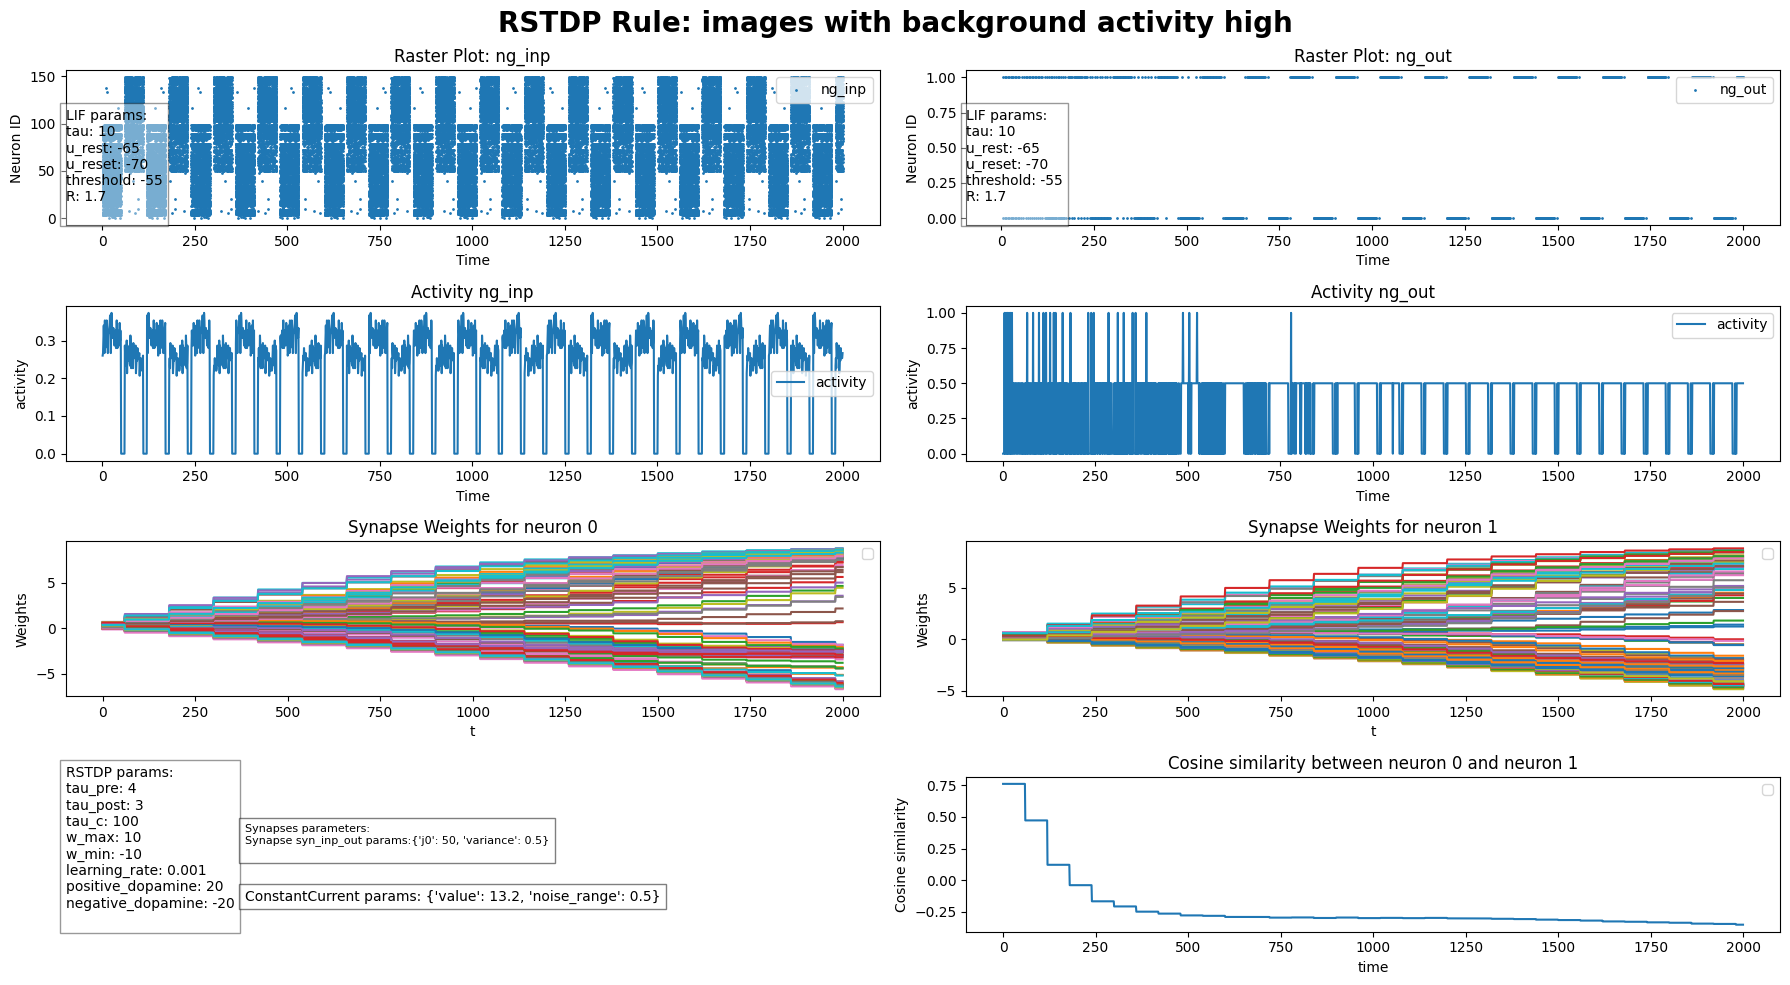

In [80]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
ng_inp.add_raster_plot(ax1, s=1)
ng_inp.add_neuron_model_params_info(ax1, model_idx=6)

ax2 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
ng_inp.add_activity_plot(ax2)

ax3 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ng_out.add_raster_plot(ax3, s=1)
ng_out.add_neuron_model_params_info(ax3, model_idx=6)

ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
ng_out.add_activity_plot(ax4)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, synapse_idx=7)
syn_inp_out.add_synapses_params_info(ax7, synapse_idx=3, text_x=0.22, text_y=0.49)
ng_inp.add_current_params_info(ax7, current_idx=2, text_x=0.22, text_y=0.2)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,neuron_1=0, neuron_2=1)

fig.suptitle("RSTDP Rule: images with background activity high", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part3-rstdp-images-background-activity-high.pdf")
plt.show()